In [1]:
import os
import time
import pickle
from collections import namedtuple

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
import torch.utils.checkpoint as checkpoint

from transformers.modeling_utils import *
from transformers.modeling_gpt2 import *
from transformers import GPT2Tokenizer

from efficientnet_pytorch import *

import matplotlib.pyplot as plt
import pickle

#from apex import amp

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Define and Load our Model

In [2]:
#efficientnet-b0-224
#efficientnet-b1-240
#efficientnet-b2-260
#efficientnet-b3-300
#efficientnet-b4-380
#efficientnet-b5-456
#efficientnet-b6-528
#efficientnet-b7-600

In [3]:
EFFNET = "efficientnet-b4"  #"efficientnet-b2" #EFFNET = "efficientnet-b0"
IMG_SIZE = 380  #260 #IMG_SIZE = 224

GPT = "gpt2"

MAX_LENGTH = 36
EFFNET_OUT = 1000

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained(GPT)

In [5]:
class EfficientNetCheck(EfficientNet):

    def run_block(self, block, drop_connect_rate):
        def custom_forward(*inputs):
            x = block(inputs[0], drop_connect_rate=drop_connect_rate)
            return x
        return custom_forward
    
    def extract_features(self, inputs):

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks) # scale drop connect_rate
            x = checkpoint.checkpoint(self.run_block(block, drop_connect_rate), x)
            #x = block(x, drop_connect_rate=drop_connect_rate)
        
        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

In [6]:
a = torch.Tensor([[1, 2], [3, 4]])
b = a.view(-1)
print(b)
c = b.view(2, -1)
print(c)


tensor([1., 2., 3., 4.])
tensor([[1., 2.],
        [3., 4.]])


In [7]:
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super().__init__()
        nx = config.n_embd
        self.ln_1 = nn.LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = nn.LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)
        
    def forward(self, x, layer_past=None, attention_mask=None, head_mask=None, use_cache=False):
        output_attn = self.attn(
            self.ln_1(x),
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
        )
        a = output_attn[0]  # output_attn: a, present, (attentions)

        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m

        outputs = [x] + output_attn[1:]
        return outputs[0], outputs[1]

class GPT2Model(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.output_hidden_states = config.output_hidden_states
        self.output_attentions = config.output_attentions

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([Block(config.n_ctx, config, scale=True) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

        self.init_weights()

    def get_input_embeddings(self):
        return self.wte


    def set_input_embeddings(self, new_embeddings):
        self.wte = new_embeddings


    def _prune_heads(self, heads_to_prune):
        for layer, heads in heads_to_prune.items():
            self.h[layer].attn.prune_heads(heads)
    
    def run_block(self, block, layer_past, attention_mask, head_mask, use_cache):
        def custom_forward(*inputs):
            x, present = block(
                inputs[0],
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=head_mask,
                use_cache=use_cache,
            )
            return x, present
        return custom_forward

    def forward(
        self,
        input_ids=None,
        past=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        use_cache=True,
    ):

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size = inputs_embeds.shape[0]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])
        if position_ids is not None:
            position_ids = position_ids.view(-1, input_shape[-1])

        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        # Attention mask.
        if attention_mask is not None:
            assert batch_size > 0, "batch_size has to be defined and > 0"
            attention_mask = attention_mask.view(batch_size, -1)
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

            attention_mask = attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
            attention_mask = (1.0 - attention_mask) * -10000.0

        head_mask = self.get_head_mask(head_mask, self.config.n_layer)

        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        presents = ()
        all_attentions = []
        all_hidden_states = ()
        for i, (block, layer_past) in enumerate(zip(self.h, past)):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states.view(*output_shape),)
            
            hidden_states, present = checkpoint.checkpoint(
                self.run_block(block, layer_past, attention_mask, head_mask[i], use_cache),
                hidden_states
            )
            
            
            '''
            outputs = block(
                hidden_states,
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=head_mask[i],
                use_cache=use_cache,
            )
            hidden_states, present = outputs[:2]
            '''
            
            if use_cache is True:
                presents = presents + (present,)

            if self.output_attentions:
                all_attentions.append(outputs[2])

        hidden_states = self.ln_f(hidden_states)

        hidden_states = hidden_states.view(*output_shape)
        # Add last hidden state
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            outputs = outputs + (presents,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            # let the number of heads free (-1) so we can extract attention even after head pruning
            attention_output_shape = input_shape[:-1] + (-1,) + all_attentions[0].shape[-2:]
            all_attentions = tuple(t.view(*attention_output_shape) for t in all_attentions)
            outputs = outputs + (all_attentions,)
        return outputs  # last hidden state, (presents), (all hidden_states), (attentions)


In [8]:

class GPT2LMHeadModel(GPT2PreTrainedModel):
    def __init__(self, config, hidden1=384, hidden2=256, efficient=EFFNET):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.init_weights()
        
        #self.efficient = EfficientNet.from_pretrained(efficient, advprop=False)
        self.efficient = EfficientNetCheck.from_pretrained(efficient, advprop=True)
        self.encoder1 = nn.Linear(config.n_embd + EFFNET_OUT, hidden1)
        self.decoder1 = nn.Linear(hidden1, config.n_embd)
        self.encoder2 = nn.Linear(config.n_embd, hidden2)
        self.decoder2 = nn.Linear(hidden2, config.n_embd)
        
        self.relu = nn.ReLU()
        
        nn.init.xavier_normal_(self.encoder1.weight, gain=0.1)
        nn.init.xavier_normal_(self.decoder1.weight, gain=0.1)
        nn.init.xavier_normal_(self.encoder2.weight, gain=0.1)
        nn.init.xavier_normal_(self.decoder2.weight, gain=0.1)
        
    def get_output_embeddings(self):
        return self.lm_head

    def prepare_inputs_for_generation(self, input_ids, past, **kwargs):
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        return {"input_ids": input_ids, "image": kwargs["image"], "past": past, "use_cache": kwargs["use_cache"]}

    def forward(self, input_ids=None, image=None, past=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=True):
        
        transformer_outputs = self.transformer(input_ids, past=past, attention_mask=attention_mask, 
                                               token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, 
                                               inputs_embeds=inputs_embeds, use_cache=use_cache)
        transformer = transformer_outputs[0]
        if MAX_LENGTH:
            efficient = self.efficient(image).unsqueeze(1).repeat(1, MAX_LENGTH, 1)
        else:
            efficient = self.efficient(image).unsqueeze(1).repeat(transformer.shape[0], transformer.shape[1], 1)
        
        
        latent = torch.cat((efficient, transformer), 2)
        
        encoded = self.relu(self.encoder1(latent))
        hidden_states = self.decoder1(encoded) + transformer
        
        encoded = self.relu(self.encoder2(hidden_states))
        hidden_states = self.decoder2(encoded) + hidden_states
        
        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs[1:]
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)

'''
class GPT2LMHeadModel(GPT2PreTrainedModel):
    def __init__(self, config, hidden_efficient=384, hidden_transformer=384, hidden=512):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.init_weights()
        
        self.hidden_efficient, self.hidden_transformer, self.hidden = hidden_efficient, hidden_transformer, hidden

        self.efficient = EfficientNetCheck.from_pretrained(EFFNET, advprop=True)
        
        self.encoder_efficient = nn.Linear(config.n_embd + EFFNET_OUT, hidden_efficient)
        self.decoder_efficient = nn.Linear(hidden_efficient, EFFNET_OUT)
        
        self.encoder_transformer = nn.Linear(config.n_embd + EFFNET_OUT, hidden_transformer)
        self.decoder_transformer = nn.Linear(hidden_transformer, config.n_embd)
        
        self.encoder = nn.Linear(config.n_embd + EFFNET_OUT, hidden)
        self.decoder = nn.Linear(hidden, config.n_embd)
        
        self.relu = nn.ReLU()
        
        # Try not tracking means or setting momentum to 0.005
        #self.bn_efficient = nn.BatchNorm1d(hidden_efficient)
        #self.bn_transformer = nn.BatchNorm1d(hidden_transformer)
        #self.bn = nn.BatchNorm1d(hidden)
        
        self.bn_efficient = nn.LayerNorm(hidden_efficient)
        self.bn_transformer = nn.LayerNorm(hidden_transformer)
        self.bn = nn.LayerNorm(hidden)
        
        gain = nn.init.calculate_gain("relu") / 10
        nn.init.xavier_normal_(self.encoder_efficient.weight, gain=gain)
        nn.init.xavier_normal_(self.decoder_efficient.weight, gain=gain)
        nn.init.xavier_normal_(self.encoder_transformer.weight, gain=gain)
        nn.init.xavier_normal_(self.decoder_transformer.weight, gain=gain)
        nn.init.xavier_normal_(self.encoder.weight, gain=gain)
        nn.init.xavier_normal_(self.decoder.weight, gain=gain)
        
    def get_output_embeddings(self):
        return self.lm_head

    def prepare_inputs_for_generation(self, input_ids, past, **kwargs):
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        return {"input_ids": input_ids, "image": kwargs["image"], "past": past, "use_cache": kwargs["use_cache"]}

    def forward(self, input_ids=None, image=None, past=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=True):
        #print(input_ids.shape)
        
        transformer_outputs = self.transformer(input_ids, past=past, attention_mask=attention_mask, 
                                               token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, 
                                               inputs_embeds=inputs_embeds, use_cache=use_cache)
        transformer = transformer_outputs[0]
        if MAX_LENGTH:
            efficient = self.efficient(image).unsqueeze(1).repeat(1, MAX_LENGTH, 1)
        else:
            efficient = self.efficient(image).unsqueeze(1).repeat(transformer.shape[0], transformer.shape[1], 1)
        
        
        latent = torch.cat((efficient, transformer), 2)  #self.relu(torch.cat((efficient, transformer), 2))
        
        encoded_efficient = self.relu(self.bn_efficient(self.encoder_efficient(latent)))
        #encoded_efficient = self.encoder_efficient(latent).view(-1, self.hidden_efficient)
        #encoded_efficient = self.relu(self.bn_efficient(encoded_efficient)).view(-1, transformer.shape[1], self.hidden_efficient)
        trans_efficient = self.decoder_efficient(encoded_efficient) + efficient
        
        encoded_transformer = self.relu(self.bn_transformer(self.encoder_transformer(latent)))
        #encoded_transformer = self.encoder_transformer(latent).view(-1, self.hidden_transformer)
        #encoded_transformer = self.relu(self.bn_transformer(encoded_transformer)).view(-1, transformer.shape[1], self.hidden_transformer)
        trans_transformer = self.decoder_transformer(encoded_transformer) + transformer
        
        trans_latent = torch.cat((trans_efficient, trans_transformer), 2)  #self.relu(torch.cat((trans_efficient, trans_transformer), 2))
        
        encoded = self.encoder(latent).view(-1, self.hidden)
        encoded = self.relu(self.bn(encoded)).view(-1, transformer.shape[1], self.hidden)
        hidden_states = self.decoder(encoded) + transformer
        
        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs[1:]
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)
'''
'''
class GPT2LMHeadModel(GPT2PreTrainedModel):
    def __init__(self, config, hidden_efficient=256, hidden_transformer=256, hidden=384):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.init_weights()
        
        self.hidden_efficient, self.hidden_transformer, self.hidden = hidden_efficient, hidden_transformer, hidden

        self.efficient = EfficientNetCheck.from_pretrained(EFFNET, advprop=True)
        
        #self.encoder_efficient = nn.Linear(config.n_embd + EFFNET_OUT, hidden_efficient)
        self.encoder_efficient = nn.GRU(config.n_embd + EFFNET_OUT, hidden_efficient, batch_first=True)
        self.decoder_efficient = nn.Linear(hidden_efficient, EFFNET_OUT)
        
        self.encoder_transformer = nn.GRU(config.n_embd + EFFNET_OUT, hidden_transformer, batch_first=True)
        self.decoder_transformer = nn.Linear(hidden_transformer, config.n_embd)
        
        self.encoder = nn.GRU(config.n_embd + EFFNET_OUT, hidden, batch_first=True)
        self.decoder = nn.Linear(hidden, config.n_embd)
        
        gain = 0.1  #nn.init.calculate_gain("relu") / 10
        
        nn.init.xavier_normal_(self.encoder_efficient.weight_ih_l0, gain=gain)
        nn.init.xavier_normal_(self.encoder_efficient.weight_hh_l0, gain=gain)
        nn.init.xavier_normal_(self.decoder_efficient.weight, gain=gain)
        
        nn.init.xavier_normal_(self.encoder_transformer.weight_ih_l0, gain=gain)
        nn.init.xavier_normal_(self.encoder_transformer.weight_hh_l0, gain=gain)
        nn.init.xavier_normal_(self.decoder_transformer.weight, gain=gain)
        
        nn.init.xavier_normal_(self.encoder.weight_ih_l0, gain=gain)
        nn.init.xavier_normal_(self.encoder.weight_hh_l0, gain=gain)
        nn.init.xavier_normal_(self.decoder.weight, gain=gain)
        
    def get_output_embeddings(self):
        return self.lm_head

    def prepare_inputs_for_generation(self, input_ids, past, **kwargs):
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        return {"input_ids": input_ids, "image": kwargs["image"], "past": past, "use_cache": kwargs["use_cache"]}

    def forward(self, input_ids=None, image=None, past=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=True):
        #print(input_ids.shape)
        
        transformer_outputs = self.transformer(input_ids, past=past, attention_mask=attention_mask, 
                                               token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, 
                                               inputs_embeds=inputs_embeds, use_cache=use_cache)
        transformer = transformer_outputs[0]
        if MAX_LENGTH:
            efficient = self.efficient(image).unsqueeze(1).repeat(1, MAX_LENGTH, 1)
        else:
            efficient = self.efficient(image).unsqueeze(1).repeat(transformer.shape[0], transformer.shape[1], 1)
        
        
        latent = torch.cat((efficient, transformer), 2)  #self.relu(torch.cat((efficient, transformer), 2))
        
        encoded_efficient = self.encoder_efficient(latent)[0]
        trans_efficient = self.decoder_efficient(encoded_efficient) + efficient
        
        encoded_transformer = self.encoder_transformer(latent)[0]
        trans_transformer = self.decoder_transformer(encoded_transformer) + transformer
        
        trans_latent = torch.cat((trans_efficient, trans_transformer), 2)
        
        encoded = self.encoder(latent)[0]
        hidden_states = self.decoder(encoded) + trans_transformer
        
        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs[1:]
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)
'''
'''
class GPT2LMHeadModel(GPT2PreTrainedModel):
    def __init__(self, config, hidden=384):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.init_weights()
        
        #self.hidden_efficient, self.hidden_transformer = hidden_efficient, hidden_transformer
        self.hidden = hidden

        self.efficient = EfficientNetCheck.from_pretrained(EFFNET, advprop=True)
        
        self.encoder = nn.GRU(config.n_embd + EFFNET_OUT, hidden, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(hidden, config.n_embd)
        
        gain = 0.1  #nn.init.calculate_gain("relu") / 10
        
        nn.init.xavier_normal_(self.encoder.weight_ih_l0, gain=gain)
        nn.init.xavier_normal_(self.encoder.weight_hh_l0, gain=gain)
        nn.init.xavier_normal_(self.encoder.weight_ih_l1, gain=gain)
        nn.init.xavier_normal_(self.encoder.weight_hh_l1, gain=gain)
        nn.init.xavier_normal_(self.decoder.weight, gain=gain)
        
    def get_output_embeddings(self):
        return self.lm_head

    def prepare_inputs_for_generation(self, input_ids, past, **kwargs):
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        return {"input_ids": input_ids, "image": kwargs["image"], "past": past, "use_cache": kwargs["use_cache"]}

    def forward(self, input_ids=None, image=None, past=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=True):
        #print(input_ids.shape)
        
        transformer_outputs = self.transformer(input_ids, past=past, attention_mask=attention_mask, 
                                               token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, 
                                               inputs_embeds=inputs_embeds, use_cache=use_cache)
        transformer = transformer_outputs[0]
        if MAX_LENGTH:
            efficient = self.efficient(image).unsqueeze(1).repeat(1, MAX_LENGTH, 1)
        else:
            efficient = self.efficient(image).unsqueeze(1).repeat(transformer.shape[0], transformer.shape[1], 1)
        
        
        latent = torch.cat((efficient, transformer), 2)  #self.relu(torch.cat((efficient, transformer), 2))
        
        encoded = self.encoder(latent)[0]
        hidden_states = self.decoder(encoded) + transformer
        
        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs[1:]
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)
'''

'\nclass GPT2LMHeadModel(GPT2PreTrainedModel):\n    def __init__(self, config, hidden=384):\n        super().__init__(config)\n        self.transformer = GPT2Model(config)\n        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)\n        self.init_weights()\n        \n        #self.hidden_efficient, self.hidden_transformer = hidden_efficient, hidden_transformer\n        self.hidden = hidden\n\n        self.efficient = EfficientNetCheck.from_pretrained(EFFNET, advprop=True)\n        \n        self.encoder = nn.GRU(config.n_embd + EFFNET_OUT, hidden, num_layers=2, batch_first=True)\n        self.decoder = nn.Linear(hidden, config.n_embd)\n        \n        gain = 0.1  #nn.init.calculate_gain("relu") / 10\n        \n        nn.init.xavier_normal_(self.encoder.weight_ih_l0, gain=gain)\n        nn.init.xavier_normal_(self.encoder.weight_hh_l0, gain=gain)\n        nn.init.xavier_normal_(self.encoder.weight_ih_l1, gain=gain)\n        nn.init.xavier_normal_(self.encoder.

In [9]:
model = GPT2LMHeadModel.from_pretrained(GPT).cuda()
torch.cuda.empty_cache()
#model(torch.LongTensor([10, 11, 12]).cuda())

Loaded pretrained weights for efficientnet-b4


In [10]:
tokenizer.encode("<|startoftext|>")
#end_of_text_token = "<|endoftext|>"

[27, 91, 9688, 1659, 5239, 91, 29]

In [11]:
#print(model)

# Define Datasets and DataLoader

In [28]:
TRAIN_IMAGES = "data/train_images"
TRAIN_CAPTIONS = "data/train_captions.pickle"

VALID_IMAGES = "data/valid_images"
VALID_CAPTIONS = "data/valid_captions.pickle"

In [13]:
Caption = namedtuple("Caption", "image text")

def load_captions(path):
    with open(path, "rb") as handler:
        captions = pickle.load(handler)
    
    captions2 = []
    cnt = 0
    for i, caption in enumerate(captions):
        tokenized = tokenizer.encode("<|endoftext|> " + caption.text + " <|endoftext|>")[:MAX_LENGTH]
        
        mask = torch.zeros(MAX_LENGTH)
        mask[torch.arange(len(tokenized))] = 1
        
        tokens = torch.zeros(MAX_LENGTH).long()
        tokens[torch.arange(len(tokenized))] = torch.LongTensor(tokenized)
        
        if len(tokenized) <= MAX_LENGTH:
            captions2.append((caption.image, tokens, mask))
            cnt += 1
    
    print(len(captions) - cnt, "captions discarded (out of range).")
    
    return captions2

train_captions = load_captions(TRAIN_CAPTIONS)
valid_captions = load_captions(VALID_CAPTIONS)

0 captions discarded (out of range).
0 captions discarded (out of range).


In [14]:
print(train_captions[0])

('57871', tensor([50256,   317,  3797, 12462,   287,   262, 15114,  1306,   284,   257,
         3155,   286,  8801,    13, 50256,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


36.0
13.88674497636683


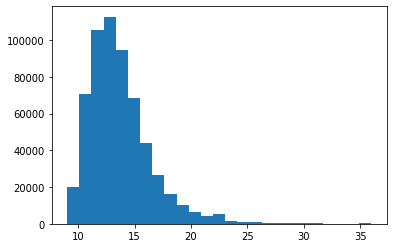

In [14]:
lens = [torch.sum(cap[2]).item() for cap in train_captions]
plt.hist(lens, bins=25)
print(max(lens))
print(sum(lens)/len(lens))
#out = len([l for l in lens if l == MAX_LENGTH])
#print(out, " (absolute) ", round(out / len(lens) * 100, 2), "% (percentual)", sep="")

In [15]:
class CaptionDataset(Dataset):
    
    tfms = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                               transforms.ToTensor(), # Then to Tensor
                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Finally normalize with ImageNet mean and variance
                               transforms.Lambda(lambda img: img * 2.0 - 1.0) # AdvProp Normalization
                              ])
    
    def __init__(self, captions, images_path, random_transform=False):
        self.captions = captions
        self.images_path = images_path
        self.random_transform = random_transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        image_id = self.captions[index][0]
        tokens = self.captions[index][1]
        mask = self.captions[index][2]

        path = os.path.join(self.images_path, image_id + ".jpg")
        image = Image.open(path).convert('RGB')
        trans = self.tfms(image)
        
        return trans.cuda(), tokens.cuda(), mask.cuda()

In [16]:
BS = 8 #2
BS_VAL = 16

train_data = CaptionDataset(train_captions, TRAIN_IMAGES)
train_generator = DataLoader(train_data, batch_size=BS, shuffle=True, num_workers=0)

valid_data = CaptionDataset(valid_captions, VALID_IMAGES)
valid_generator = DataLoader(valid_data, batch_size=BS_VAL, shuffle=False, num_workers=0)

In [17]:
t = time.time()
for images, texts, masks in train_generator:
    print(len(texts))
    break
print(time.time()-t)

8
0.2184145450592041


# Training Hyperparameters

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
model.train()
pass
#model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

# Training Loop

In [22]:
def validate():
    print("Validating...")
    model.eval()
    
    # Evaluate
    sum_loss, start = 0, time.time()
    with torch.no_grad():
        for idx, (images, texts, masks) in enumerate(valid_generator):
            images_c, texts_c, masks_c = images.cpu(), texts.cpu(), masks.cpu()
            
            try:
                loss, _, _ = model(texts, images, labels=texts, attention_mask=masks)
                sum_loss += loss.item()
            except:
                print(idx)
                print(images_c, texts_c, masks_c)
                print([tokenizer.decode(text) for text in texts_c])
                print(loss.item())
    
    print("Valid Loss:", round(sum_loss / len(valid_generator), 3))
    print("Time: ", round(time.time() - start), "s")
    
    model.train()
    
    return sum_loss / len(valid_generator)

In [23]:
"""
Valid Loss: 7.265
Time:  460 s
11355.9609375
"""

#validate()

'\nValid Loss: 7.265\nTime:  460 s\n11355.9609375\n'

In [24]:
from tensorboardX import SummaryWriter

writer = SummaryWriter("runs/gru_xavier-gain-div-10_384-finalx2_0")
writer.add_scalar("valid_loss", 7.265, 0)

In [25]:
EPOCHS = 10
ACCUM = 1
EVERY = 100 * ACCUM
EVERY_VAL = 4000 * ACCUM
EVERY_SAVE = 4000 * ACCUM

best = 10e9
for epoch in range(EPOCHS):
    print("\nEpoch", epoch + 1)
    sum_loss, start = 0, time.time()
    for idx, (images, texts, masks) in enumerate(train_generator):
        
        loss, outputs, _ = model(texts, images, labels=texts, attention_mask=masks)
        
        sum_loss += loss.item()
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        loss.backward()
        
        if idx % ACCUM == ACCUM - 1:
            optimizer.step()
            optimizer.zero_grad()
        
        if idx % EVERY == EVERY - 1:
            print(round(100 * BS * idx / len(train_captions), 1), "% completed;", round(time.time() - start), "s")
            print("Loss:", round(sum_loss / EVERY, 3))
            writer.add_scalar("train_loss", sum_loss / EVERY, epoch * len(train_generator) + idx)
            writer.add_scalar("time", start, epoch * len(train_generator) + idx)
            
            sum_loss = 0
        
        if idx % EVERY_VAL == EVERY_VAL - 1:
            outputs = None
            act = validate()
            if act < best:
                best = act
                torch.save(model.state_dict(), str(round(best, 3)) + ".torch")
            writer.add_scalar("valid_loss", act, epoch * len(train_generator) + idx)
            
        
        if idx % EVERY_SAVE == EVERY_SAVE - 1:
            print("Model checkpoint saved!")
            torch.save(model.state_dict(), "last_checkpoint.torch")
    
    torch.save(model.state_dict(), str(epoch) + ".torch")


Epoch 1
0.1 % completed; 83 s
Loss: 1.494
0.3 % completed; 166 s
Loss: 1.193
0.4 % completed; 249 s
Loss: 1.137
0.5 % completed; 331 s
Loss: 1.14
0.7 % completed; 414 s
Loss: 1.151
0.8 % completed; 496 s
Loss: 1.113
0.9 % completed; 579 s
Loss: 1.081
1.1 % completed; 661 s
Loss: 1.067
1.2 % completed; 744 s
Loss: 1.093
1.4 % completed; 827 s
Loss: 1.059
1.5 % completed; 909 s
Loss: 1.055
1.6 % completed; 991 s
Loss: 1.033
1.8 % completed; 1074 s
Loss: 1.038
1.9 % completed; 1158 s
Loss: 1.031
2.0 % completed; 1243 s
Loss: 1.018
2.2 % completed; 1326 s
Loss: 1.024
2.3 % completed; 1411 s
Loss: 1.024
2.4 % completed; 1494 s
Loss: 1.025
2.6 % completed; 1577 s
Loss: 1.008
2.7 % completed; 1659 s
Loss: 1.018
2.8 % completed; 1742 s
Loss: 0.98
3.0 % completed; 1824 s
Loss: 1.013
3.1 % completed; 1907 s
Loss: 0.998
3.2 % completed; 1990 s
Loss: 0.985
3.4 % completed; 2073 s
Loss: 0.986
3.5 % completed; 2156 s
Loss: 0.998
3.6 % completed; 2239 s
Loss: 0.979
3.8 % completed; 2321 s
Loss: 0.96

C:\Users\klein\anaconda3\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Valid Loss: 0.935
Time:  614 s
Model checkpoint saved!
5.5 % completed; 4011 s
Loss: 0.956
5.7 % completed; 4093 s
Loss: 0.953
5.8 % completed; 4175 s
Loss: 0.946
5.9 % completed; 4257 s
Loss: 0.922
6.1 % completed; 4339 s
Loss: 0.962
6.2 % completed; 4421 s
Loss: 0.955
6.4 % completed; 4503 s
Loss: 0.938
6.5 % completed; 4585 s
Loss: 0.933
6.6 % completed; 4667 s
Loss: 0.939
6.8 % completed; 4749 s
Loss: 0.925
6.9 % completed; 4831 s
Loss: 0.922
7.0 % completed; 4913 s
Loss: 0.937
7.2 % completed; 4995 s
Loss: 0.945
7.3 % completed; 5077 s
Loss: 0.94
7.4 % completed; 5159 s
Loss: 0.92
7.6 % completed; 5241 s
Loss: 0.934
7.7 % completed; 5323 s
Loss: 0.93
7.8 % completed; 5405 s
Loss: 0.955
8.0 % completed; 5486 s
Loss: 0.936
8.1 % completed; 5569 s
Loss: 0.952
8.2 % completed; 5650 s
Loss: 0.939
8.4 % completed; 5732 s
Loss: 0.948
8.5 % completed; 5814 s
Loss: 0.899
8.7 % completed; 5896 s
Loss: 0.921
8.8 % completed; 5978 s
Loss: 0.937
8.9 % completed; 6059 s
Loss: 0.909
9.1 % comple

33.8 % completed; 24460 s
Loss: 0.839
33.9 % completed; 24543 s
Loss: 0.845
34.1 % completed; 24625 s
Loss: 0.858
34.2 % completed; 24707 s
Loss: 0.866
34.3 % completed; 24789 s
Loss: 0.843
34.5 % completed; 24872 s
Loss: 0.839
34.6 % completed; 24954 s
Loss: 0.849
34.7 % completed; 25036 s
Loss: 0.862
34.9 % completed; 25118 s
Loss: 0.841
35.0 % completed; 25200 s
Loss: 0.83
35.1 % completed; 25282 s
Loss: 0.831
35.3 % completed; 25364 s
Loss: 0.853
35.4 % completed; 25447 s
Loss: 0.835
35.6 % completed; 25529 s
Loss: 0.853
35.7 % completed; 25611 s
Loss: 0.82
35.8 % completed; 25693 s
Loss: 0.826
36.0 % completed; 25775 s
Loss: 0.854
36.1 % completed; 25857 s
Loss: 0.86
36.2 % completed; 25939 s
Loss: 0.867
36.4 % completed; 26021 s
Loss: 0.838
36.5 % completed; 26103 s
Loss: 0.852
36.6 % completed; 26185 s
Loss: 0.844
36.8 % completed; 26267 s
Loss: 0.855
36.9 % completed; 26350 s
Loss: 0.871
37.0 % completed; 26432 s
Loss: 0.855
37.2 % completed; 26514 s
Loss: 0.855
37.3 % complete

61.9 % completed; 44814 s
Loss: 0.791
62.1 % completed; 44897 s
Loss: 0.84
62.2 % completed; 44980 s
Loss: 0.818
62.3 % completed; 45063 s
Loss: 0.838
62.5 % completed; 45146 s
Loss: 0.833
62.6 % completed; 45230 s
Loss: 0.796
62.7 % completed; 45313 s
Loss: 0.803
62.9 % completed; 45397 s
Loss: 0.801
63.0 % completed; 45480 s
Loss: 0.802
63.1 % completed; 45564 s
Loss: 0.797
63.3 % completed; 45647 s
Loss: 0.797
63.4 % completed; 45730 s
Loss: 0.836
63.5 % completed; 45813 s
Loss: 0.812
63.7 % completed; 45897 s
Loss: 0.824
63.8 % completed; 45980 s
Loss: 0.817
63.9 % completed; 46063 s
Loss: 0.822
64.1 % completed; 46147 s
Loss: 0.85
64.2 % completed; 46230 s
Loss: 0.838
64.3 % completed; 46313 s
Loss: 0.822
64.5 % completed; 46398 s
Loss: 0.794
64.6 % completed; 46484 s
Loss: 0.82
64.8 % completed; 46569 s
Loss: 0.804
64.9 % completed; 46652 s
Loss: 0.81
Validating...
Valid Loss: 0.804
Time:  610 s
Model checkpoint saved!
65.0 % completed; 47349 s
Loss: 0.795
65.2 % completed; 47432

90.0 % completed; 65771 s
Loss: 0.821
90.2 % completed; 65855 s
Loss: 0.754
90.3 % completed; 65940 s
Loss: 0.79
90.4 % completed; 66024 s
Loss: 0.802
90.6 % completed; 66109 s
Loss: 0.801
90.7 % completed; 66192 s
Loss: 0.785
90.8 % completed; 66278 s
Loss: 0.8
91.0 % completed; 66362 s
Loss: 0.823
91.1 % completed; 66446 s
Loss: 0.79
91.3 % completed; 66530 s
Loss: 0.793
91.4 % completed; 66614 s
Loss: 0.79
91.5 % completed; 66699 s
Loss: 0.786
91.7 % completed; 66783 s
Loss: 0.797
91.8 % completed; 66867 s
Loss: 0.809
91.9 % completed; 66953 s
Loss: 0.786
Validating...
Valid Loss: 0.79
Time:  637 s
Model checkpoint saved!
92.1 % completed; 67682 s
Loss: 0.805
92.2 % completed; 67766 s
Loss: 0.796
92.3 % completed; 67850 s
Loss: 0.792
92.5 % completed; 67932 s
Loss: 0.802
92.6 % completed; 68014 s
Loss: 0.802
92.7 % completed; 68098 s
Loss: 0.795
92.9 % completed; 68184 s
Loss: 0.793
93.0 % completed; 68270 s
Loss: 0.797
93.1 % completed; 68356 s
Loss: 0.773
93.3 % completed; 68441 s

KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load("weights/mlp_primitive/1.torch"))

<All keys matched successfully>

In [26]:
 st = model.state_dict()

In [29]:
model.load_state_dict(st)

<All keys matched successfully>

# Testing Loop

In [51]:
class CaptionDatasetTest(Dataset):
    
    tfms = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                               transforms.ToTensor(), # Then to Tensor
                               transforms.Lambda(lambda img: img * 2.0 - 1.0) # AdvProp Normalization
                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Finally normalize with ImageNet mean and variance
                              ])
    
    tfms2 = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                              ])
    
    def __init__(self, images_path):
        self.images_path = images_path
        self.names = [file for file in os.listdir(images_path) if file[-4:] == ".jpg"]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        path = os.path.join(self.images_path, self.names[index])
        image = Image.open(path).convert('RGB')
        
        trans = self.tfms(image)
        
        return np.array(self.tfms2(image)), trans.cuda()

TEST_IMAGES = "data/test_images"
test_data = CaptionDatasetTest(TEST_IMAGES)
test_generator = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [52]:
MAGIC_TOKEN = tokenizer.encode("<|endoftext|>")[0]

def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:] # last n indices sorted, rest random
    top_prob = probs[ind] # get the top n probs
    top_prob = top_prob / np.sum(top_prob) # normalize to have probability 1
    choice = np.random.choice(n, 1, p=top_prob) # choose 1 from top_prob distro
    token_id = ind[choice][0] # get the index in the original list
    return int(token_id)

def generate_some_text(input_str, image, text_len=30):
    cur_ids = torch.tensor(tokenizer.encode(input_str)).unsqueeze(0).long().cuda()
    #cur_ids = torch.zeros((1, 0)).unsqueeze(0).long().cuda()
    
    model.eval()
    global MAX_LENGTH
    global MAGIC_TOKEN
    
    with torch.no_grad():
        for i in range(text_len):
            outputs = model(cur_ids, image, labels=cur_ids)
            loss, logits = outputs[:2]
            softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(only one) batch and the last predicted embedding
            next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=10) #Randomly(from the given probability distribution) choose the next word from the top n words
            if next_token_id == MAGIC_TOKEN:
                break
            cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().cuda() * next_token_id], dim = 1) # Add the last word
            MAX_LENGTH += 1

        output_list = list(cur_ids.squeeze().to('cpu').numpy())[1:]
        output_text = tokenizer.decode(output_list)
        print(output_text)

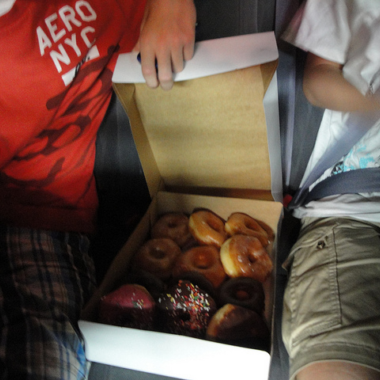

 A man standing next to a box filled with donuts.


In [57]:
MAX_LENGTH = 0
for image, tensor in test_generator:
    display(Image.fromarray(image[0].numpy()))
    #generate_some_text("<|endoftext|>", image=tensor)
    #print(tensor.shape, torch.Tensor(tokenizer.encode("<|endoftext|>")).unsqueeze(0).long().cuda().shape)
    
    beam_output = model.generate(
        torch.Tensor(tokenizer.encode("<|endoftext|>")).unsqueeze(0).long().cuda(), 
        image=tensor, 
        pad_token_id=tokenizer.eos_token_id, 
        num_beams=256, 
        no_repeat_ngram_size=2, 
        early_stopping=True,
        num_return_sequences=1
    )
    
    if len(beam_output.shape) == 1:
        beam_output.unsqueeze(0)
        
    output = beam_output.to('cpu').numpy()[:, 1:].tolist()
    captions = [tokenizer.decode([t for t in o if t != tokenizer.eos_token_id])
                for o in output]
    
    for caption in captions:
        print(caption)
    
    break

### BLEU testing

In [16]:
from nltk.translate.bleu_score import sentence_bleu

In [17]:
print(len(valid_captions))
valid_captions[0]

25014


('462904',
 tensor([50256,   317,  1588,  8223,  5055,  2641,   286,   257, 13510,  3112,
            13, 50256,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
dict_bleu_captions = {}
for image_id, caption, mask in valid_captions:
    if image_id not in dict_bleu_captions:
        dict_bleu_captions[image_id] = []
    dict_bleu_captions[image_id].append((caption, mask))

bleu_captions = []
for image in dict_bleu_captions:
    bleu_captions.append((image, [cap for cap in dict_bleu_captions[image]]))

In [19]:
#print(bleu_captions[0])
len(bleu_captions)

5000

In [20]:
import string

class CaptionDatasetBLEU(Dataset):
    
    tfms = transforms.Compose([transforms.Resize(IMG_SIZE), # First set the min dimension to 380
                               transforms.CenterCrop(IMG_SIZE), # Then center crop
                               transforms.ToTensor(), # Then to Tensor
                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Finally normalize with ImageNet mean and variance
                               transforms.Lambda(lambda img: img * 2.0 - 1.0) # AdvProp Normalization
                              ])
    
    def __init__(self, captions, images_path, random_transform=False):
        self.captions = captions
        self.images_path = images_path
        self.random_transform = random_transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        image_id = self.captions[index][0]
        correct = [tokenizer.decode([caption[0][t] for t in range(len(caption[0])) if caption[1][t]][1:-1])
                   for caption in self.captions[index][1]]
        correct = [sent[1:].lower().translate(str.maketrans('', '', string.punctuation)) for sent in correct]
        #print(correct)

        path = os.path.join(self.images_path, image_id + ".jpg")
        image = Image.open(path).convert('RGB')
        trans = self.tfms(image)
        
        return trans.cuda(), correct

bleu_data = CaptionDatasetBLEU(bleu_captions, VALID_IMAGES)
bleu_generator = DataLoader(bleu_data, batch_size=1, shuffle=False, num_workers=0)

In [21]:
t = time.time()
for images, texts in bleu_generator:
    print(len(texts))
    break
print(time.time()-t)

5
0.06832718849182129


In [50]:
start = 1
t, cnt = time.time(), 1
total = len(bleu_captions) - 1  # 20
MAX_LENGTH = 0

b1 = b2 = b3 = b4 = 0
for tensor, references in bleu_generator:
    if cnt < start:
        cnt += 1
        continue
    
    references = [c[0] for c in references]
    #print(references)
    #print(references)
    #print(tensor)
    beam_output = model.generate(
        torch.Tensor(tokenizer.encode("<|endoftext|>")).unsqueeze(0).long().cuda(), 
        image=tensor, 
        pad_token_id=tokenizer.eos_token_id, 
        num_beams=64,
        no_repeat_ngram_size=2, 
        early_stopping=True,
        num_return_sequences=1
    )
    
    if len(beam_output.shape) == 1:
        beam_output.unsqueeze(0)
        
    output = beam_output.to('cpu').numpy()[:, 1:].tolist()
    caption = tokenizer.decode([t for t in output[0] if t != tokenizer.eos_token_id])
    caption = caption[1:].lower().translate(str.maketrans('', '', string.punctuation))
    #break
    #print(caption)
    
    b1 += sentence_bleu(references, caption, weights=(1, 0, 0, 0))
    b2 += sentence_bleu(references, caption, weights=(0, 1, 0, 0))
    b3 += sentence_bleu(references, caption, weights=(0, 0, 1, 0))
    b4 += sentence_bleu(references, caption, weights=(0, 0, 0, 1))
    
    if cnt % 100 == 0:
        print(f"{cnt}/{total} {time.time() - t:.1f} s")
        
    if cnt == 100 or cnt == 1000:
        print("\nB1:", round(b1 / cnt, 3))
        print("B2:", round(b2 / cnt, 3))
        print("B3:", round(b3 / cnt, 3))
        print("B4:", round(b4 / cnt, 3))
    
    if cnt == total:
        break
    cnt += 1
    
print("\nB1:", round(b1 / total, 3))
print("B2:", round(b2 / total, 3))
print("B3:", round(b3 / total, 3))
print("B4:", round(b4 / total, 3))

KeyboardInterrupt: 

In [39]:
b11 = b1
b22 = b2
b33 = b3
b44 = b4
cntt = cnt

In [ ]:
0.707 0.548 0.410 0.304

In [37]:
cnt -= 1
cnt

3247

In [49]:
print("\nB1:", round(b1 / cnt, 3))
print("B2:", round(b2 / cnt, 3))
print("B3:", round(b3 / cnt, 3))
print("B4:", round(b4 / cnt, 3))


B1: 0.431
B2: 0.368
B3: 0.303
B4: 0.26


In [46]:
start = 1
t, cnt = time.time(), 1
total = len(bleu_captions)  # 20
MAX_LENGTH = 0

b1 = b2 = b3 = b4 = 0
for tensor, references in bleu_generator:
    if cnt < start:
        cnt += 1
        continue
    
    references = [c[0] for c in references]
    #print(references)
    #print(references)
    #print(tensor)
    beam_output = model.generate(
        torch.Tensor(tokenizer.encode("<|endoftext|>")).unsqueeze(0).long().cuda(), 
        image=tensor, 
        pad_token_id=tokenizer.eos_token_id, 
        num_beams=5,
        no_repeat_ngram_size=2, 
        early_stopping=True,
        num_return_sequences=1
    )
    
    if len(beam_output.shape) == 1:
        beam_output.unsqueeze(0)
        
    output = beam_output.to('cpu').numpy()[:, 1:].tolist()
    caption = tokenizer.decode([t for t in output[0] if t != tokenizer.eos_token_id])
    caption = caption[1:].lower().translate(str.maketrans('', '', string.punctuation))
    #break
    #print(caption)
    
    b1 += sentence_bleu(references, caption, weights=(1, 0, 0, 0))
    b2 += sentence_bleu(references, caption, weights=(0, 1, 0, 0))
    b3 += sentence_bleu(references, caption, weights=(0, 0, 1, 0))
    b4 += sentence_bleu(references, caption, weights=(0, 0, 0, 1))
    
    if cnt % 100 == 0:
        print(f"{cnt}/{total} {time.time() - t:.1f} s")
        
    if cnt == 100 or cnt == 1000:
        print("\nB1:", round(b1 / cnt, 3))
        print("B2:", round(b2 / cnt, 3))
        print("B3:", round(b3 / cnt, 3))
        print("B4:", round(b4 / cnt, 3))
    
    if cnt == total:
        break
    cnt += 1
    
print("\nB1:", round(b1 / total, 3))
print("B2:", round(b2 / total, 3))
print("B3:", round(b3 / total, 3))
print("B4:", round(b4 / total, 3))

100/5000 117.2 s

B1: 0.929
B2: 0.806
B3: 0.667
B4: 0.573
200/5000 234.4 s
300/5000 348.5 s
400/5000 463.6 s


KeyboardInterrupt: 

In [42]:
b1 = b2 = b3 = b4 = 0

In [43]:
b1

0